# Fitting Auto-Regressive process to simulated calcium signals - Pseudoinverse

spikes times and neuron ids imported from simulated brunel network, brunel_network.ipynb
low-pass filtering of these spikes has been considered as simulated calcium signals. Fitting an Auto-regressive process to these signals will end up to a system of least squares which can be solved by pseudo-inverse of signals.

Different analysis has been presented which all will have their own explanations.

*Due to the restrictions of memory codes have been written in separate block in order to have more control on the process of running. There shall be some hypothesis and techniques which can solve these restriction and the whole process could be less expenssive.*

*For an end-to-end version, everthing including saving, naming and loading the files as well as analysis for different parameters shall get done systematically.*

*As the process of fitting takes long, the whole analysis can't be systematic. So, in order to plot figures the results has been recorded one by one in another file then plots are made. Further information will be found in the read me.*

In [71]:
%matplotlib notebook

In [2]:
import numpy as np
#import nest
import sklearn.metrics
import matplotlib.pyplot as plt
import scipy.stats
import scipy
import array
import collections
from scipy.linalg import expm
import random

**Making spikes from timing and ids of neuron.**

In [2]:
senders = np.load("sp_senders-10e7-ms.npy")
times = np.load("sp_times-10e7-ms.npy")

In [3]:
spikes = np.histogram2d(senders, times, bins=[range(1, 1252), np.arange(0, 10000000+1, 1)])[0]

In [4]:
np.save("spikes-10e7-ms-bin1.npy", spikes)

In [2]:
spikes = np.load("spikes-60e6-ms.npy")

In [3]:
np.shape(spikes)

(1250, 6000000)

### Calcium from spikes

*Exact digital simulation of time-invariant linear systems with applications to neuronal modeling
Stefan Rotter & Markus Diesmann, Biological Cybernetics volume 81, pages381–402 (1999)*

tau: time constant of calcium. 

In [ ]:
N = np.shape(spikes)[0]
wup_time = 1000
spikes = spikes[:, wup_time:]
sim_dur = np.shape(spikes)[1]
calcium = np.zeros((N, sim_dur))
tau = 200
dt = 1
const_A = np.exp((-1/tau)*dt)

calcium[:, 0] = spikes[:, 0]

for t in range(1, sim_dur):
    #calcium[:, t] = np.dot(const_A, calcium[:, t-1]) + spikes[:, t]
    calcium[:, t] = const_A*calcium[:, t-1] + spikes[:, t]
    
#there is no need for convolutional for loops!

In [ ]:
np.save("calcium-60e6-tau-1.npy", calcium)

In [2]:
calcium = np.load("calcium-60e6-tau-1.npy")

## AR - Pseudoinverse 

regression process will end up to 

$Y_{k} = [y_{k}, y_{k+1}, y_{k+2}, ..., y_{n}] $       as Y

$Y_{-k} = [y_{0}, y_{1}, y_{2}, ..., y_{n-k-1}, y_{n-k}]$      as Y_prime

$Y_{k} = BY_{-k}$  $\Rightarrow$  $B = Y_{k}Y_{-k}^{+}$ 

k is lag or down-sampling step. this is a novel method to do a down-sampling on signal by cutting as long as the step from first and end of signal. It is like to use signal in between of down-sampling point as another data set.

In [158]:
spikes = calcium[:, 1000:]
del calcium

In [ ]:
from datetime import datetime
datetime.now()

In [ ]:
k = 10
Y = spikes[:, k:]
Y_prime = spikes[:, :-k]
Y_pinv = np.linalg.pinv(Y_prime)
del Y_prime

from datetime import datetime
datetime.now()

In [ ]:
A = Y @ Y_pinv
del Y_pinv, Y

In [8]:
np.save("est-60e6-tau1-ds200.npy", A)

**Correlation Coefficient**
To measure the performance of estimation, first we need corr. coef. In order to have it properly, we first remove the diagonal. Because it induces high auto-correlation.

In [9]:
G = np.load("connectivity-60e6-ms.npy")
G = G - (np.diag(np.diag(G)))

In [10]:
A = A - (np.diag(np.diag(A)))

In [11]:
np.corrcoef(G.flatten(), A.flatten())[0, 1]

-0.20000104479844846

**3-class performance measurement** The block of analysis which comes up with this criterion will be presented.

class i: exc, unconnected, inh

$\dfrac{correct(i)}{\sum_{i} estimated(i)}$

In [12]:
G[G == 8.0] = 1.0
G[G == -48.0] = -1.0

A_thresholded = np.copy(A)
A_thresholded[A_thresholded > 0.0042] = 1.0
A_thresholded[A_thresholded < -0.01] = -1.0
A_thresholded[(-0.01 <= A_thresholded) & (A_thresholded <= 0.0042)] = 0.0

confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten(), labels=[1.0, 0.0, -1.0])
confusion_matrix

array([[    348,  118500,       0],
       [  96219, 1317716,       0],
       [   9569,   20148,       0]])

In [13]:
a = 0
for l in range(0, 3):
    a += confusion_matrix[l, l]/(np.sum(confusion_matrix[l, :]))

a

0.9348775983388697

Following analysis is an argument to show how good is the new 3-class criterion and also t ofind the best theshold.
The histogram is the entries of estimated matrix corresponding to ground truth. Obviously, the are overlaps. So, the best estimation is to find the best threshold between histograms.

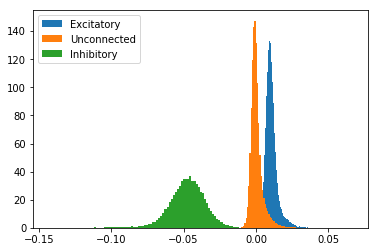

In [40]:
a_positive = A[G > 0]
a_zero = A[G == 0]
a_negative = A[G < 0]


plt.figure()
plt.hist(a_positive.flatten(), density=True, bins=100, label='Excitatory')
plt.hist(a_zero.flatten(), density=True, bins=100, label='Unconnected')
plt.hist(a_negative.flatten(), density=True, bins=100, label='Inhibitory')
plt.legend()
plt.show()

In [115]:
counter_i = 0
counter_j = 0

thresholds_exc = np.arange(-0.0084, 0.0168, 0.0006)
thresholds_inh = np.arange(-0.088, 0.072, 0.004)

acc = np.zeros((43, 40))

for i in thresholds_exc:
    
    counter_j = 0
    
    for j in thresholds_inh:
        
        A_thresholded = np.copy(A)
        A_thresholded[A_thresholded > i] = 8.0
        A_thresholded[A_thresholded < j] = -48.0
        A_thresholded[(j <= A_thresholded) & (A_thresholded <= i)] = 0.0
        
        confusion_matrix = sklearn.metrics.confusion_matrix(G.flatten(), A_thresholded.flatten())
        
        a = 0
        for l in range(0, 3):
            a += confusion_matrix[l,l]/(np.sum(confusion_matrix[l, :]))
            
        acc[counter_i, counter_j] = a
        #acc[counter_i, counter_j] = np.trace(confusion_matrix)
        
        counter_j += 1
        
    counter_i += 1

In [ ]:
thresholds_exc = np.arange(-0.0084, 0.0168, 0.0006)
thresholds_inh = np.arange(-0.088, 0.072, 0.004)
thresholds_inh[20]

<IPython.core.display.Javascript object>


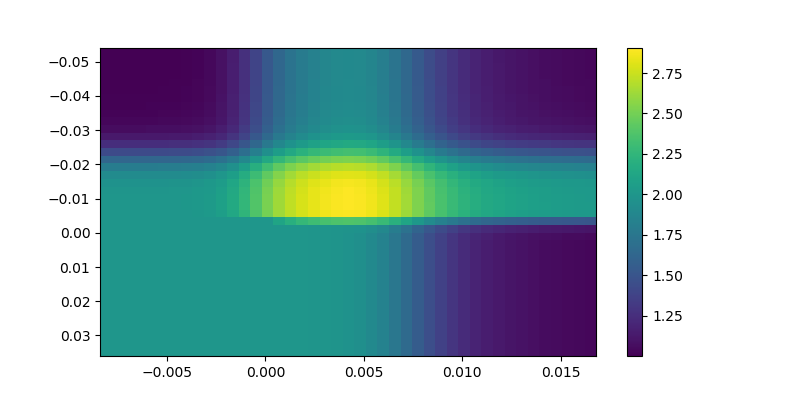

In [92]:
plt.figure(figsize=(8, 4))
plt.imshow(acc.T, interpolation='none', extent=[-0.0084, 0.0168, 0.036, -0.054], aspect='auto')
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


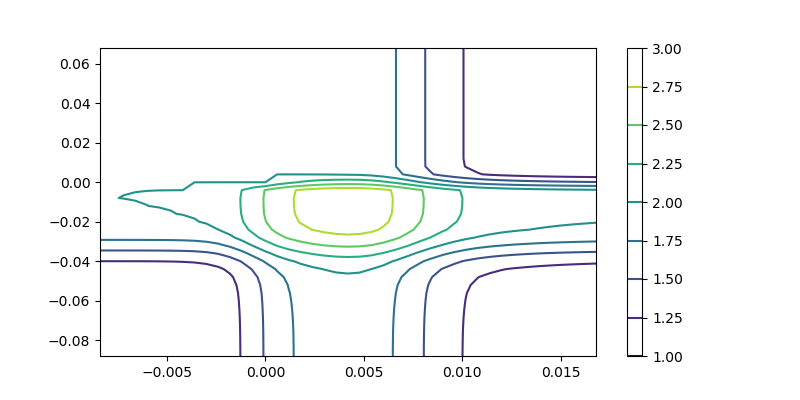

In [93]:
accx = acc_precision[:, :-1]
plt.figure(figsize=(8, 4))
plt.contour(threshodls_exc, thresholds_inh, acc.T)
plt.colorbar()
plt.show()

# 2-class performance measurement
## 1- ROC
### 1-a) Threshold for connected/unconnected

<IPython.core.display.Javascript object>


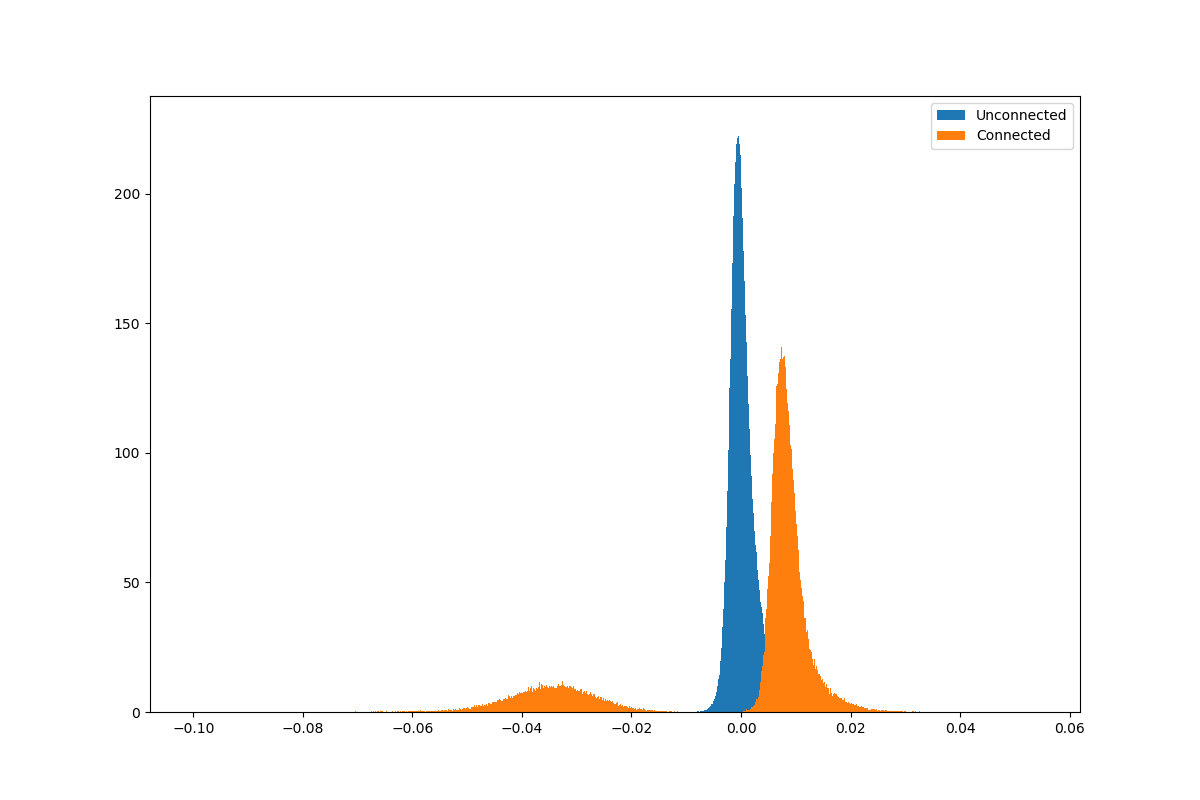

In [13]:
#Decision Making Block

connected = A[G != 0]
unconnected = A[G == 0]

plt.figure(figsize=(12, 8))

plt.hist(unconnected.flatten(), density=True, bins=1000, label='Unconnected')
plt.hist(connected.flatten(), density=True, bins=1000, label='Connected')
#plt.hist(a_negative.flatten(), density=True, bins=100, label='Inhibitory')
plt.legend()
plt.show()

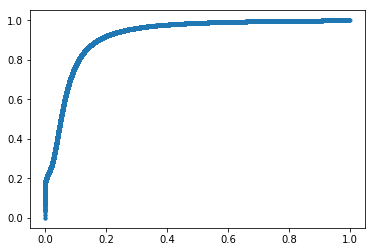

0.9221768169801471

In [5]:
#ground truth needs to be binary for conn/unconn analysis
G00_exc = np.copy(G) 
G00_exc[G00_exc != 0] = 1

#without absolut value the inhibitory part would be estimated totaly false, 
#so the maximum of ROC curve would be 0.8
A_abs_exc = abs(A) 

fpr_exc, tpr_exc, tr_exc = sklearn.metrics.roc_curve(G00_exc.flatten(), A_abs_exc.flatten())
plt.figure()
plt.plot(fpr_exc, tpr_exc, ".-")
plt.show()

sklearn.metrics.roc_auc_score(G00_exc.flatten(), A_abs_exc.flatten())

## Effect of hiden neurons

In [54]:
N = 1250
p = 50  #perscentage of observed nodes
K = int((p*N)/100)  #number of observed nodes
R = np.array(random.sample(range(N),K)) #array of random labels
np.save('randm_labels_90.npy', R)

In [5]:
spikes = np.load("calcium-60e6-tau-5.npy")

In [3]:
R = np.load('randm_labels_90.npy')

In [55]:
spikes_partial = spikes[R, :][:]

In [56]:
np.shape(spikes_partial)

(625, 5999000)

In [8]:
np.save('spikes_partial_90.npy', spikes_partial)

In [4]:
spikes_partial = np.load('spikes_partial_90.npy')

In [57]:
from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 10, 15, 54, 51, 545351)

In [58]:
ds_step = 10
Y = spikes_partial[:, :-ds_step]
Y_ = np.linalg.pinv(Y)
del Y

from datetime import datetime
datetime.now()

datetime.datetime(2021, 5, 10, 16, 41, 9, 949423)

In [59]:
Xprime = spikes_partial[:, ds_step:]
A = Xprime @ Y_

In [60]:
G = np.load('connectivity-60e6-ms.npy')

In [61]:
G_partial = G[R, :][:, R]

In [62]:
G_partial = G_partial - (np.diag(np.diag(G_partial)))
A = A - (np.diag(np.diag(A)))

In [64]:
np.corrcoef(G_partial.flatten(), A.flatten())[0, 1]

0.734473795632554

In [65]:
G_partial[G_partial == 8.0] = 1.0
G_partial[G_partial == -48.0] = -1.0

A_thresholded = np.copy(A)
A_thresholded[A_thresholded > 0.0042] = 1.0
A_thresholded[A_thresholded < -0.01] = -1.0
A_thresholded[(-0.01 <= A_thresholded) & (A_thresholded <= 0.0042)] = 0.0

confusion_matrix = sklearn.metrics.confusion_matrix(G_partial.flatten(), A_thresholded.flatten(), labels=[1.0, 0.0, -1.0])
confusion_matrix

array([[ 25986,   4003,      0],
       [ 71941, 276823,   4700],
       [     0,      1,   7171]])

In [66]:
a = 0
for l in range(0, 3):
    a += confusion_matrix[l, l]/(np.sum(confusion_matrix[l, :]))

a

2.649549987039947

<IPython.core.display.Javascript object>


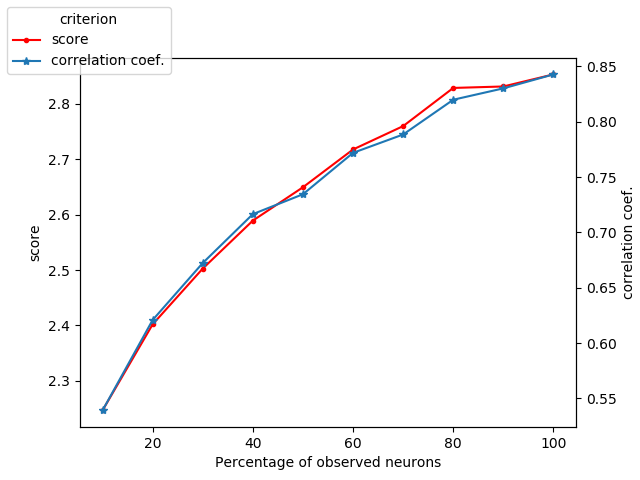

In [72]:
hiden_corr = np.array([0.539247, 0.620877, 0.672366, 0.716509, 0.734473, 0.771857, 0.788433, 0.81983, 0.830096, 0.842708])
hiden_score = np.array([2.246305, 2.401833, 2.502591, 2.589275, 2.649549, 2.717814, 2.760051, 2.829015, 2.831665, 2.853483])
percentages = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

f = plt.figure(1)
ax1 = plt.subplot(111)
ax1.plot(percentages, hiden_score, '.-', color = 'red', label = 'score')
ax2 = ax1.twinx()
ax2.plot(percentages, hiden_corr, '*-', label = 'correlation coef.')
#ax1.set_xscale('log')
ax1.set_xlabel('Percentage of observed neurons')
ax1.set_ylabel('score')
ax2.set_ylabel('correlation coef.')
f.legend(title = 'criterion', loc=2)

### Problem of matrix exponential and logarithm

In [307]:
G = np.load('connectivity-60e6-ms.npy')
A = np.load('est-60e6-tau100-ds1.npy')

#conl = scipy.linalg.logm(G)
#estl = scipy.linalg.logm(A)

cone = scipy.linalg.expm(1e-3*G)

#conl = conl - (np.diag(np.diag(conl)))
#estl = estl - (np.diag(np.diag(estl)))

#conlR = np.real(conl)
#conlI = np.imag(conl)
#estR = np.real(estl)
#estI = np.imag(estl)

#cone = scipy.linalg.expm(conl)
#este = scipy.linalg.expm(estl)

In [264]:
G = G - (np.diag(np.diag(G)))
estl = estl - (np.diag(np.diag(estl)))
A = A - (np.diag(np.diag(A)))

In [265]:
estR = estR - (np.diag(np.diag(estR)))
estI = estI - (np.diag(np.diag(estI)))
conlR = conlR - (np.diag(np.diag(conlR)))
conlI = conlI - (np.diag(np.diag(conlI)))

In [308]:
cone = cone - (np.diag(np.diag(cone)))
A = A - (np.diag(np.diag(A)))
np.corrcoef(cone.flatten(), A.flatten())[0, 1]

0.7667632018017349

In [266]:
np.corrcoef(G.flatten(), estl.flatten())[0, 1]

(-0.002929105868444658-0.00023029650030476073j)

In [267]:
np.corrcoef(conlR.flatten(), estR.flatten())[0, 1]

0.0018035676682177377

In [268]:
np.corrcoef(conlI.flatten(), estI.flatten())[0, 1]

-0.0008735459091892952

In [269]:
np.corrcoef(G.flatten(), conlR.flatten())[0, 1]

0.0922850734555866

# Useful function :D

In [23]:
import collections

In [24]:
collections.Counter(G.flatten())

Counter({0.0: 1413877, 8.0: 118853, -48.0: 29770})